In [1]:
import torch
import torch.nn as nn
import torch_geometric
from src.layer.encoders import TrigonometricEncoder
from src.model.wavegc import WaveGCNet
from src.transforms.spectral import WaveGCSpectralTransform

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

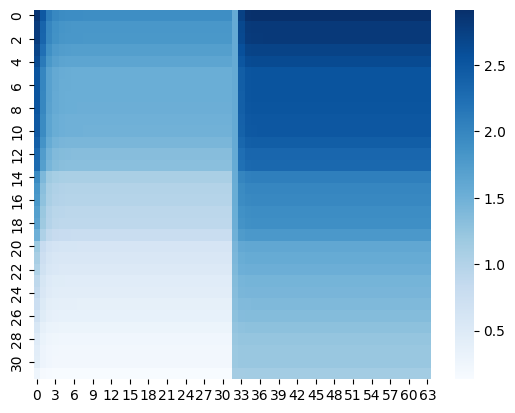

In [2]:
eigvs = torch.tensor(np.random.uniform(0,2, (1, 32) ),
                      dtype=torch.float32).sort(
    axis=1,descending=True).values
d = 64

pe = TrigonometricEncoder(d, 100, project=False)
pos = pe(eigvs)
sns.heatmap(pos.detach(), cmap='Blues')

In [3]:
from src.datasets.amazon import AmazonComputerDataset
from src.datasets.Ps import PeptidesStructDataset
from torch_geometric.utils.convert import to_networkx, from_networkx
import networkx as nx

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = AmazonComputerDataset(root='./data', name='Photo', threshold=0)

TypeError: AmazonComputerDataset.__init__() got an unexpected keyword argument 'threshold'

In [5]:
G = to_networkx(dataset._data)
G = nx.to_undirected(G)
nx.number_connected_components(G)

136

In [6]:
components = nx.connected_components(G)
for comp in components:
    print(len(comp)/G.number_of_nodes())

0.9786928104575163
0.00026143790849673205
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00026143790849673205
0.00013071895424836603
0.00026143790849673205
0.00013071895424836603
0.0005228758169934641
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00026143790849673205
0.00026143790849673205
0.00026143790849673205
0.00013071895424836603
0.00026143790849673205
0.00026143790849673205
0.00013071895424836603
0.000392156862745098
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00026143790849673205
0.00013071895424836603
0.00013071895424836603
0.0005228758169934641
0.00013071895424836603
0.00026143790849673205
0.0005228758169934641
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.000130718954248366

In [4]:
from torch.utils.data import DataLoader
from src.datasets.collate import collate_fn

In [9]:
loader = DataLoader(dataset=dataset, collate_fn=collate_fn, batch_size=1)

In [11]:
inp_dim = dataset._data.x.shape[1]
emb_dim, pe_dim = 32, 16
eigvs_dim = dataset._data.eigvs.shape[1]
hidden_dim = 32
lape_hidden_num = 1
out_dim = dataset._data.y.unique().shape[0]
K, J = 6, 3

In [12]:
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.nn.conv import MessagePassing

class SimpleGCN(nn.Module):
    def __init__(self, inp_dim, out_dim, hidden_dim, hidden_num=3, **kwargs):
        super().__init__()
        self.inp_dim, self.out_dim = inp_dim, out_dim
        self.hidden_dim = hidden_dim
        act = nn.GELU
        self.conv = nn.ModuleList([pyg_nn.GCN(
                                    in_channels=inp_dim,
                                    hidden_channels=hidden_dim,
                                    num_layers=hidden_num,
                                    act = act(),
                                )])
        for i in range(hidden_num):
            self.conv.append( pyg_nn.GCN(
                    in_channels=hidden_dim,
                    hidden_channels=hidden_dim,
                    num_layers=3,
                    act = act())
            )
            if i!= hidden_num-1:
                self.conv.append(nn.BatchNorm1d(hidden_dim))
                #self.conv.append(act())
        self.out = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x, edge_index, **kwargs):
        for module in self.conv: 
            if isinstance(module, (pyg_nn.GCN, MessagePassing)): 
                x = module(x, edge_index)
            else:
                x = module(x) 
                
        return self.out(x)


In [13]:
import hydra
print(hydra.__version__)

1.3.2


In [14]:
wave_flag = True

In [15]:
model = WaveGCNet(
        inp_dim=inp_dim,
        out_dim=out_dim,
        emb_dim=emb_dim, 
        pe_dim=pe_dim, 
        eigvs_dim=eigvs_dim,
        lape_hidden_num=lape_hidden_num,
        hidden_dim=hidden_dim, 
        heads_num=4,
        scale=torch.tensor([1.0]*J), 
        num_layers=4,
        mpnn="gcn",
        K=K,
        J=J,
        tight_frames=True,
        dropout=0.2,
        ffn_hidden_num=2,
        mpnn_hidden_num=1,
        eps=100,
        aggr="sum",
    ) if wave_flag else SimpleGCN(inp_dim, out_dim, hidden_dim=64)

In [16]:
print("Number of Parameters: ", sum([param.numel() for param in model.parameters()]))

Number of Parameters:  124345


In [5]:
dataset = PeptidesStructDataset(root='./data', split='train', force_reload=True)

Processing...
Processing test dataset: 100%|██████████| 2331/2331 [00:00<00:00, 50670.76it/s]
Done!
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(
Processing...


Computing global max dimensions...
Global max_nodes: 444, max_k: 444

Processing train split...
Extracted 10873 individual graphs
Applying spectral transform and padding...
  Processing graph 0/10873
  Processing graph 1000/10873
  Processing graph 2000/10873
  Processing graph 3000/10873
  Processing graph 4000/10873
  Processing graph 5000/10873
  Processing graph 6000/10873
  Processing graph 7000/10873
  Processing graph 8000/10873
  Processing graph 9000/10873
  Processing graph 10000/10873
Saving 10873 padded graphs to train.pt
Finished processing train split

Processing val split...
Extracted 2331 individual graphs
Applying spectral transform and padding...
  Processing graph 0/2331
  Processing graph 1000/2331
  Processing graph 2000/2331
Saving 2331 padded graphs to val.pt
Finished processing val split

Processing test split...
Extracted 2331 individual graphs
Applying spectral transform and padding...
  Processing graph 0/2331
  Processing graph 1000/2331
  Processing graph 2

Done!


In [6]:
import inspect

print(inspect.getsource(collate_fn))

def collate_fn(dataset_items: list):
    """
    Pads spatial dimensions (N) to N_max.
    Stacks spectral dimensions (k) based on the computed pre-transform.
    """
    batch_size = len(dataset_items)

    # 1. Determine Dimensions
    # Spatial: Max nodes in this batch
    max_nodes = max([item.num_nodes for item in dataset_items])

    # Spectral: Max eigenvalues available in this batch
    # (If using fixed top_k in transform, this is constant. If pct, it varies)
    max_k = max([item.eigvs.shape[1] for item in dataset_items])

    feat_dim = dataset_items[0].x.shape[1]

    # 2. Allocate Dense Tensors
    x_padded = torch.zeros((batch_size, max_nodes, feat_dim))
    eigvs_padded = torch.zeros((batch_size, max_k))
    U_padded = torch.zeros((batch_size, max_nodes, max_k))

    train_mask = torch.zeros((batch_size, max_nodes), dtype=torch.bool)
    test_mask = torch.zeros((batch_size, max_nodes), dtype=torch.bool)
    # Mask: True = Padding/Ignored
    eigvs_mask = torch.ones((batc

In [7]:
# Get a single data sample
sample = dataset[0]

# Check the type
print("Sample type:", type(sample))

# Check what attributes are available (call keys as a method if it's a dict)
if isinstance(sample, dict):
    print("Available keys:", list(sample.keys()))
else:
    print("Available attributes:", sample.keys())

# View the masks
if hasattr(sample, 'train_mask') or (isinstance(sample, dict) and 'train_mask' in sample):
    train_mask = sample['train_mask'] if isinstance(sample, dict) else sample.train_mask
    print("\nTrain mask:", train_mask)
    print("Train mask shape:", train_mask.shape)
    print("Number of training nodes:", train_mask.sum().item())

if hasattr(sample, 'test_mask') or (isinstance(sample, dict) and 'test_mask' in sample):
    test_mask = sample['test_mask'] if isinstance(sample, dict) else sample.test_mask
    print("\nTest mask:", test_mask)
    print("Test mask shape:", test_mask.shape)
    print("Number of test nodes:", test_mask.sum().item())

# View other useful info
if isinstance(sample, dict):
    print("\nNode features shape:", sample['x'].shape)
    print("Edge index shape:", sample['edge_index'].shape)
    print("Number of nodes:", sample['x'].shape[0])
    print("Number of edges:", sample['edge_index'].shape[1])
    
    # Check spectral features
    if 'eigvs' in sample:
        print("\nEigenvalues shape:", sample['eigvs'].shape)
    if 'U' in sample:
        print("Eigenvectors shape:", sample['U'].shape)
    if 'y' in sample:
        print("Label shape:", sample['y'].shape)
else:
    print("\nNumber of nodes:", sample.num_nodes)
    print("Number of edges:", sample.num_edges)
    print("Node features shape:", sample.x.shape)
    print("Edge index shape:", sample.edge_index.shape)
    
    # Check spectral features
    if hasattr(sample, 'eigvs'):
        print("\nEigenvalues shape:", sample.eigvs.shape)
    if hasattr(sample, 'U'):
        print("Eigenvectors shape:", sample.U.shape)

Sample type: <class 'torch_geometric.data.data.Data'>
Available attributes: ['eigvs', 'y', 'U', 'edge_index', 'num_real_k', 'eigvs_mask', 'x']

Number of nodes: 338
Number of edges: 682
Node features shape: torch.Size([338, 9])
Edge index shape: torch.Size([2, 682])

Eigenvalues shape: torch.Size([1, 444])
Eigenvectors shape: torch.Size([338, 444])


In [8]:
sample = dataset[0]
print("Sample type:", type(sample))
print("Number of nodes:", sample.num_nodes)

Sample type: <class 'torch_geometric.data.data.Data'>
Number of nodes: 338


In [9]:
# Access the entire list of graphs
data_list = dataset._data_list

print(f"Total number of graphs: {len(data_list)}")

# Access individual graphs
first_graph = data_list[0]
print(f"\nFirst graph:")
print(f"  Nodes: {first_graph.num_nodes}")
print(f"  Edges: {first_graph.num_edges}")
print(f"  Features shape: {first_graph.x.shape}")
print(f"  Label: {first_graph.y}")

# Or iterate through them
for i, graph in enumerate(data_list[:3]):  # First 3 graphs
    print(f"\nGraph {i}:")
    print(f"  Nodes: {graph.num_nodes}")
    print(f"  Label shape: {graph.y.shape}")

Total number of graphs: 10873

First graph:
  Nodes: 338
  Edges: 682
  Features shape: torch.Size([338, 9])
  Label: tensor([[ 4.5942,  4.1395,  4.9547,  4.2022,  3.7022,  4.7691,  2.9831,  2.9949,
          1.6674, -1.5496,  1.6010]])

Graph 0:
  Nodes: 338
  Label shape: torch.Size([1, 11])

Graph 1:
  Nodes: 220
  Label shape: torch.Size([1, 11])

Graph 2:
  Nodes: 155
  Label shape: torch.Size([1, 11])


In [10]:
dataset._data_list

[Data(x=[338, 9], edge_index=[2, 682], y=[1, 11], eigvs=[1, 444], U=[338, 444], eigvs_mask=[444], num_real_k=338),
 Data(x=[220, 9], edge_index=[2, 446], y=[1, 11], eigvs=[1, 444], U=[220, 444], eigvs_mask=[444], num_real_k=220),
 Data(x=[155, 9], edge_index=[2, 324], y=[1, 11], eigvs=[1, 444], U=[155, 444], eigvs_mask=[444], num_real_k=155),
 Data(x=[99, 9], edge_index=[2, 200], y=[1, 11], eigvs=[1, 444], U=[99, 444], eigvs_mask=[444], num_real_k=99),
 Data(x=[120, 9], edge_index=[2, 244], y=[1, 11], eigvs=[1, 444], U=[120, 444], eigvs_mask=[444], num_real_k=120),
 Data(x=[71, 9], edge_index=[2, 152], y=[1, 11], eigvs=[1, 444], U=[71, 444], eigvs_mask=[444], num_real_k=71),
 Data(x=[178, 9], edge_index=[2, 364], y=[1, 11], eigvs=[1, 444], U=[178, 444], eigvs_mask=[444], num_real_k=178),
 Data(x=[205, 9], edge_index=[2, 410], y=[1, 11], eigvs=[1, 444], U=[205, 444], eigvs_mask=[444], num_real_k=205),
 Data(x=[194, 9], edge_index=[2, 390], y=[1, 11], eigvs=[1, 444], U=[194, 444], eigvs_

In [11]:
sample = dataset[0]
print(f"Has eigenvalues: {hasattr(sample, 'eigvs')}")
if hasattr(sample, 'eigvs'):
    print(f"Eigenvalues shape: {sample.eigvs.shape}")
    print(f"Eigenvectors shape: {sample.U.shape}")

Has eigenvalues: True
Eigenvalues shape: torch.Size([1, 444])
Eigenvectors shape: torch.Size([338, 444])
